In [16]:
import feature_extraction as fe

import numpy as np

import os
import random
import pickle
import warnings
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

seed = 3
random.seed(seed)
torch.manual_seed(seed)

warnings.filterwarnings('ignore')

In [17]:
def data_batcher(data, batch_size):
    random.shuffle(data)
    return [data[i:i + batch_size] for i in range(0, len(data), batch_size)]

In [18]:
dataset = 'GTZAN'
new_spects = False


dataset_filename = f'../datasets/{dataset}.gui'
pickle_filename = f'./feats_spects-pickles/{dataset_filename.split("/")[-1][:-4]}_spects.pkl'

#spects, labels = fe.extract_spectrograms(dataset_filename)
if new_spects or not os.path.isfile(pickle_filename):
    spects, labels = fe.extract_spectrograms(dataset_filename)
    with open(pickle_filename, 'wb') as f:
        pickle.dump([spects, labels], f)
else:
    with open(pickle_filename, 'rb') as f:
        spects, labels = pickle.load(f)
    print(f'{spects.shape[0]} spectrograms extracted')

1000 spectrograms extracted


In [19]:
scaler = StandardScaler()
#scaled_feats = scaler.fit_transform(feats)

x_trainval, x_test, y_trainval, y_test = train_test_split(spects, labels, test_size=0.2)
x_train, x_val, y_train, y_val = train_test_split(x_trainval, y_trainval, test_size=0.25)

train_data = [(x, y) for x, y in zip(x_train, y_train)]
val_data = [(x, y) for x, y in zip(x_val, y_val)]
test_data = [(x, y) for x, y in zip(x_test, y_test)]

print(len(train_data), "training samples")
print(len(val_data), "validation samples")
print(len(test_data), "test samples")

600 training samples
200 validation samples
200 test samples


In [117]:
class CNNClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, embedding_size, num_layers):
        super(CNNClassifier, self).__init__()
        
        self.conv1d1 = nn.Conv1d(128, 64, 5, padding = 2) 
        self.conv1d1_bn = nn.BatchNorm1d(64, momentum=0.9) 
        self.pool1 = torch.nn.MaxPool1d(kernel_size=4) 
        self.dropout1 = nn.Dropout(0.5)
        
        self.conv1d2 = nn.Conv1d(64, 32, 3, padding = 1) 
        self.conv1d2_bn = nn.BatchNorm1d(32, momentum=0.9)
        self.pool2 = torch.nn.MaxPool1d(kernel_size=2) #58/2=29
        self.dropout2 = nn.Dropout(0.5)
        
        self.conv1d3 = nn.Conv1d(32, 16, 3, padding = 1) 
        self.conv1d3_bn = nn.BatchNorm1d(16, momentum=0.9)
        self.pool3 = torch.nn.MaxPool1d(kernel_size=2) 
        self.dropout3 = nn.Dropout(0.3)
        
        self.rnn = torch.nn.LSTM(16, 16, num_layers=1, batch_first=True, bidirectional=False)
        
        self.fc1 = nn.Linear(16, num_classes)
        
    
    def forward(self, x):
    
        out = x.permute(0,2,1)
        
        #Layer1
        out = F.relu(self.conv1d1_bn(self.conv1d1(out)))
        out = self.pool1(out)
        #out = self.dropout1(out)
        
        #Layer2
        out = F.relu(self.conv1d2_bn(self.conv1d2(out)))
        out = self.pool2(out)
        #out = self.dropout2(out)
        
        #Layer3
        out = F.relu(self.conv1d3_bn(self.conv1d3(out)))
        out = self.pool3(out)
        out = self.dropout3(out)
        
        # LSTM
        out = out.permute(0,2,1)
        out, (h_n, c_n) = self.rnn(out)
        out = h_n[-1,:,:]
        
        #FC
        out = self.fc1(out)
        
        return out

In [118]:
def train(log_interval, model, device, data_batches, optimizer, epoch):
    losses = []
    len_glob_data = np.prod(np.array(np.array(data_batches).shape[:-1]))
    
    model.train()
    
    total_loss = 0
    ncorrect = 0
    nsentences = 0
    ntokens = 0
    niterations = 0
    
    for i, batch in enumerate(data_batches):
        x, y = list(zip(*batch))
        
        X = [torch.from_numpy(d[0]) for d in batch]
        X_lengths = [x.numel() for x in X]
        ntokens += sum(X_lengths)
        X_lengths = torch.tensor(X_lengths, dtype=torch.long, device=device)
        
        
        # Move tensors to the configured device
        data = torch.from_numpy(np.array(x)).float().to(device)
        target = torch.from_numpy(np.array(y)).to(device)
        
        # clear all the gradients of the optimized tensors
        optimizer.zero_grad()
        
        # Forward pass
        output = model(data)#, X_lengths)
        loss = criterion(output, target)
        
        # Backward and optimize
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
        
        if (i+1) % log_interval == 0:
            print(f'Train Epoch: {epoch+1} [{(i+1)*len(data)}/{len_glob_data} ({str(int(100. * (i+1)*len(data) / len_glob_data)).zfill(2)}%)]\tLoss: {round(loss.item(),6)}')
    return np.array(losses).mean()

In [119]:
def validate(model, device, data_batches):
    len_glob_data = np.prod(np.array(np.array(data_batches).shape[:-1]))
    
    model.eval()  # let's put the model in evaluation mode

    validation_loss = []
    correct = 0
    with torch.no_grad():  # we don't need gradient computation at all
        for i, batch in enumerate(data_batches):
            x, y = list(zip(*batch))
        
            data = torch.from_numpy(np.array(x)).float().to(device)
            target = torch.from_numpy(np.array(y)).to(device)
            
            output = model(data)
            loss = criterion(output, target)
            
            validation_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    validation_loss = np.array(validation_loss).mean()
    accuracy = 100. * correct / len_glob_data

    print(f'\nValidation set: Average loss: {round(validation_loss, 4)}, Accuracy: {correct}/{len_glob_data} ({int(accuracy)}%)\n')
    
    return accuracy, validation_loss

In [120]:
# Hyperparameters
input_size = 640
hidden_size = [256, 128, 64]
num_classes = 10
n_features = [256, 128, 64] #Get from xtrain (see BatchNorm1d)
kernel_size = 5
train_batch_size = 100
valid_batch_size = 100
embedding_size = 64
num_layers = 1


num_epochs = 100
learning_rate = 0.00005

In [121]:
train_data_batches = data_batcher(train_data, train_batch_size)
val_data_batches = data_batcher(val_data, valid_batch_size)

model = CNNClassifier(input_size, hidden_size, num_classes, embedding_size, num_layers).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_losses = []
valid_losses = []
accuracies = []

for epoch in range(num_epochs):
    
    train_loss = train(2, model, device, train_data_batches, optimizer, epoch)
    train_losses.append(train_loss)

    accuracy, valid_loss = validate(model, device, val_data_batches)
    valid_losses.append(valid_loss)
    accuracies.append(accuracy)

Train Epoch: 1 [200/600 (33%)]	Loss: 2.292829
Train Epoch: 1 [400/600 (66%)]	Loss: 2.302998
Train Epoch: 1 [600/600 (100%)]	Loss: 2.286558

Validation set: Average loss: 2.2972, Accuracy: 21/200 (10%)

Train Epoch: 2 [200/600 (33%)]	Loss: 2.284272
Train Epoch: 2 [400/600 (66%)]	Loss: 2.29658
Train Epoch: 2 [600/600 (100%)]	Loss: 2.275602

Validation set: Average loss: 2.286, Accuracy: 21/200 (10%)

Train Epoch: 3 [200/600 (33%)]	Loss: 2.270092
Train Epoch: 3 [400/600 (66%)]	Loss: 2.280718
Train Epoch: 3 [600/600 (100%)]	Loss: 2.263421

Validation set: Average loss: 2.2786, Accuracy: 21/200 (10%)

Train Epoch: 4 [200/600 (33%)]	Loss: 2.261912
Train Epoch: 4 [400/600 (66%)]	Loss: 2.269217
Train Epoch: 4 [600/600 (100%)]	Loss: 2.258444

Validation set: Average loss: 2.272, Accuracy: 21/200 (10%)

Train Epoch: 5 [200/600 (33%)]	Loss: 2.259966
Train Epoch: 5 [400/600 (66%)]	Loss: 2.264978
Train Epoch: 5 [600/600 (100%)]	Loss: 2.244165

Validation set: Average loss: 2.2666, Accuracy: 22/200 

Train Epoch: 41 [400/600 (66%)]	Loss: 2.130199
Train Epoch: 41 [600/600 (100%)]	Loss: 2.087771

Validation set: Average loss: 2.1507, Accuracy: 49/200 (24%)

Train Epoch: 42 [200/600 (33%)]	Loss: 2.111696
Train Epoch: 42 [400/600 (66%)]	Loss: 2.127604
Train Epoch: 42 [600/600 (100%)]	Loss: 2.10818

Validation set: Average loss: 2.1497, Accuracy: 48/200 (24%)

Train Epoch: 43 [200/600 (33%)]	Loss: 2.120667
Train Epoch: 43 [400/600 (66%)]	Loss: 2.123117
Train Epoch: 43 [600/600 (100%)]	Loss: 2.11986

Validation set: Average loss: 2.148, Accuracy: 46/200 (23%)

Train Epoch: 44 [200/600 (33%)]	Loss: 2.110577
Train Epoch: 44 [400/600 (66%)]	Loss: 2.119924
Train Epoch: 44 [600/600 (100%)]	Loss: 2.098295

Validation set: Average loss: 2.147, Accuracy: 49/200 (24%)

Train Epoch: 45 [200/600 (33%)]	Loss: 2.101665
Train Epoch: 45 [400/600 (66%)]	Loss: 2.128029
Train Epoch: 45 [600/600 (100%)]	Loss: 2.084559

Validation set: Average loss: 2.1421, Accuracy: 51/200 (25%)

Train Epoch: 46 [200/600 (

Train Epoch: 81 [600/600 (100%)]	Loss: 1.925832

Validation set: Average loss: 2.0406, Accuracy: 73/200 (36%)

Train Epoch: 82 [200/600 (33%)]	Loss: 1.944203
Train Epoch: 82 [400/600 (66%)]	Loss: 1.95858
Train Epoch: 82 [600/600 (100%)]	Loss: 1.942022

Validation set: Average loss: 2.0267, Accuracy: 77/200 (38%)

Train Epoch: 83 [200/600 (33%)]	Loss: 1.9224
Train Epoch: 83 [400/600 (66%)]	Loss: 1.965823
Train Epoch: 83 [600/600 (100%)]	Loss: 1.933194

Validation set: Average loss: 2.0259, Accuracy: 77/200 (38%)

Train Epoch: 84 [200/600 (33%)]	Loss: 1.929334
Train Epoch: 84 [400/600 (66%)]	Loss: 1.945712
Train Epoch: 84 [600/600 (100%)]	Loss: 1.922432

Validation set: Average loss: 2.0303, Accuracy: 75/200 (37%)

Train Epoch: 85 [200/600 (33%)]	Loss: 1.942594
Train Epoch: 85 [400/600 (66%)]	Loss: 1.96637
Train Epoch: 85 [600/600 (100%)]	Loss: 1.929941

Validation set: Average loss: 2.0218, Accuracy: 74/200 (37%)

Train Epoch: 86 [200/600 (33%)]	Loss: 1.924895
Train Epoch: 86 [400/600 (

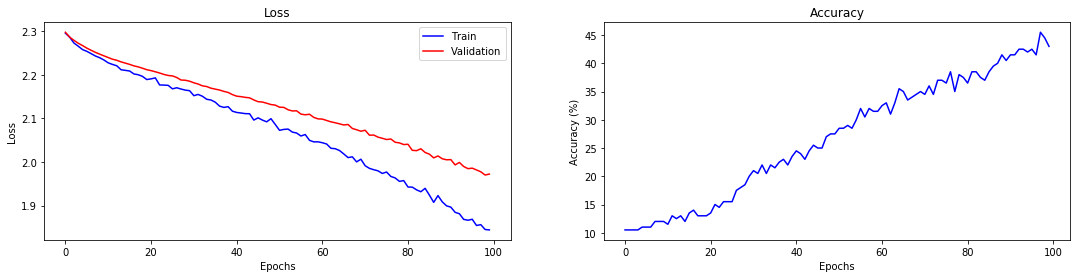

In [122]:
fig = plt.figure()
fig.subplots_adjust(right=2.5)

ax1 = fig.add_subplot(121)
ax1.set_title('Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.plot(train_losses, 'b-', label='Train')
ax1.plot(valid_losses, 'r-', label='Validation')
ax1.legend(loc='upper right')

ax1 = fig.add_subplot(122)
ax1.set_title('Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy (%)')
ax1.plot(accuracies, 'b-')

plt.show()